In [19]:
!pip install ray==2.9.3 pydantic

In [20]:
! git clone https://github.com/ray-project/ray.git
# for deterministic behavior let's pinned to a specific commit at the time this example was pushed
! pushd ~/ray && git reset --hard 11fb194050426ce27f75cd5c8f1d77f65fdfd0bc && popd

fatal: destination path 'ray' already exists and is not an empty directory.
~/ray ~
HEAD is now at 11fb194050 [Data] Move `BlockWritePathProvider` to separate file (#40302)
~


In [10]:
! cp -r  ray/doc/source/templates/05_dreambooth_finetuning ./dreambooth_finetuning

In [11]:
!pip install huggingface_hub
#python dreambooth_finetuning/dreambooth/download_example_dataset.py /persist-data/images-own/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.8.2
    Uninstalling fsspec-2022.8.2:
      Successfully uninstalled fsspec-2022.8.2


In [12]:
# Prepare the directories expected by the stable diffusion fine-tuning example. Note: These directories are created in a shared filesystem, which would be also accesible on ray head and worker pods
!mkdir -p /persist-data/images-own
!mkdir -p /persist-data/images-reg
!mkdir -p /persist-data/images-new
!mkdir -p /persist-data/model-orig
!mkdir -p /persist-data/model-tuned

In [21]:
# Download the dog image dataset
! python dreambooth_finetuning/dreambooth/download_example_dataset.py /persist-data/images-own/

Fetching 5 files: 100%|███████████████████████████| 5/5 [00:00<00:00, 20.43it/s]


In [22]:
# Download the model checkpoint from huggingface hub and cache it a shared directory in the shared filesystem
! python dreambooth_finetuning/dreambooth/cache_model.py --model_dir=/persist-data/model-orig --model_name=CompVis/stable-diffusion-v1-4 --revision=b95be7d6f134c3a9e62ee616f310733567f069ce

Fetching 31 files: 100%|██████████████████████| 31/31 [00:00<00:00, 5516.01it/s]


In [23]:
# Connect to the ray cluster
import ray
from ray.job_submission import JobSubmissionClient
client = JobSubmissionClient("ray://ray-cluster-kuberay-head-svc:10001")

In [24]:
# https://docs.ray.io/en/latest/train/examples/pytorch/dreambooth_finetuning.html#step-3-create-the-regularization-images
# create a ray job which prepares the regularization data. Ray worker pods have mounted the shared filesystem at /data. 
#### NOTE:
# The default number of workers used by generate.py is 4. If you do not have sufficient number of GPUs in the cluster please update the generate.py to use lesser number of workers at line https://github.com/ray-project/ray/blob/master/doc/source/templates/05_dreambooth_finetuning/dreambooth/generate.py#L51
# kubectl exec --tty -i tensorflow-0 -c tensorflow-container -n example -- /bin/bash
# Update the file `dreambooth_finetuning/dreambooth/generate.py`

job_id = client.submit_job(
    entrypoint="python generate.py --model_dir='/data/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce' --output_dir='/data/images-reg' --prompts='photo of a dog' --num_samples_per_prompt=100 --use_ray_data",
    # Path to the local directory that contains the entrypoint file.
    runtime_env={
        "working_dir": "/home/jovyan/dreambooth_finetuning/dreambooth", # upload the local working directory to ray workers
        "pip": ["IPython",
                "datasets",
                "torch==2.0.1",
                "accelerate==0.20.3",
                "bitsandbytes==0.39.1",
                "diffusers==0.19.3",
                "flax==0.6.11",
                "ipywidgets",
                "huggingface_hub==0.16.2",
                "numpy==1.24.4",
                "transformers==4.30.2",
                "pyarrow",
                "torchvision==0.15.2"]
    }
)
print("jobid:", job_id)

2023-10-17 23:52:56,449	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_36fd7cebcbc6ffe2.zip.
2023-10-17 23:52:56,452	INFO packaging.py:518 -- Creating a file package for local directory '/home/jovyan/dreambooth_finetuning/dreambooth'.


jobid: raysubmit_uCgwcqXZKTPVD9DY


In [25]:
# Replace with the jobid from the previous cell
!ray job status raysubmit_uCgwcqXZKTPVD9DY  --address "ray://ray-cluster-kuberay-head-svc:10001" 

# some helpful commands to stop and delete ray jobs
# !ray job stop <jobid> --address "ray://ray-cluster-kuberay-head-svc:10001" 
# !ray job delete <jobid> --address "ray://ray-cluster-kuberay-head-svc:10001" 

Job submission server address: http://10.4.4.9:8265

------------------------------------------
Job 'raysubmit_uCgwcqXZKTPVD9DY' succeeded
------------------------------------------



In [26]:
# https://docs.ray.io/en/latest/train/examples/pytorch/dreambooth_finetuning.html#step-4-fine-tune-the-model
# Start the distributed ray train job on the ray cluster. This specific example would use 4 ray workers (each worker using 1 GPU)
job_id = client.submit_job(
    entrypoint="python train.py --model_dir='/data/model-orig/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce' --output_dir='/data/model-tuned' --instance_images_dir='/data/images-own' --instance_prompt='photo of unqtkn dog' --class_images_dir='/data/images-reg' --class_prompt='photo of a dog' --train_batch=2 --lr=5e-6 --num_epochs=2 --max_train_steps=100 --num_workers=4",
    runtime_env={
        "working_dir": "/home/jovyan/dreambooth_finetuning/dreambooth",
        "pip": ["IPython",
                "datasets",
                "torch==2.0.1",
                "accelerate==0.20.3",
                "bitsandbytes==0.39.1",
                "diffusers==0.19.3",
                "flax==0.6.11",
                "ipywidgets",
                "huggingface_hub==0.16.2",
                "numpy==1.24.4",
                "transformers==4.30.2",
                "pyarrow",
                "torchvision==0.15.2"]
    }
)
print("jobid:", job_id)

2023-10-18 00:21:41,852	INFO dashboard_sdk.py:385 -- Package gcs://_ray_pkg_36fd7cebcbc6ffe2.zip already exists, skipping upload.


jobid: raysubmit_MPLv7gycz3vnMuHX


In [28]:
!ray job status raysubmit_MPLv7gycz3vnMuHX  --address "ray://ray-cluster-kuberay-head-svc:10001" 

Job submission server address: http://10.4.4.9:8265

------------------------------------------
Job 'raysubmit_MPLv7gycz3vnMuHX' succeeded
------------------------------------------



In [29]:
# https://docs.ray.io/en/latest/train/examples/pytorch/dreambooth_finetuning.html#step-5-generate-images-of-the-subject
# Do inference with the tuned model
job_id = client.submit_job(
    entrypoint="python generate.py --model_dir='/data/model-tuned'  --output_dir='/data/images-new' --prompts='photo of a unqtkn dog in a bucket' --num_samples_per_prompt=5",
    runtime_env={
        "working_dir": "/home/jovyan/dreambooth_finetuning/dreambooth",
        "pip": ["IPython",
                "datasets",
                "torch==2.0.1",
                "accelerate==0.20.3",
                "bitsandbytes==0.39.1",
                "diffusers==0.19.3",
                "flax==0.6.11",
                "ipywidgets",
                "huggingface_hub==0.16.2",
                "numpy==1.24.4",
                "transformers==4.30.2",
                "pyarrow",
                "torchvision==0.15.2"]
    }
)
print("jobid:", job_id)

2023-10-18 00:37:21,374	INFO dashboard_sdk.py:385 -- Package gcs://_ray_pkg_36fd7cebcbc6ffe2.zip already exists, skipping upload.


jobid: raysubmit_jbUPz8WVRtxRUR2j


In [30]:
!ray job status raysubmit_jbUPz8WVRtxRUR2j  --address "ray://ray-cluster-kuberay-head-svc:10001" 

Job submission server address: http://10.4.4.9:8265
Status for job 'raysubmit_jbUPz8WVRtxRUR2j': RUNNING
Status message: Job is currently running.


In [31]:
! ls /persist-data/images-new

0-9a5c433ab2dcdf09ffb4cbe038ad04bb90bc7b8e.jpg
1-8f26e567ad3616ee2ba4c1036fa97d0678ccdf73.jpg
2-d93a4e0d85981c02916d6306f9d66370360fe267.jpg
3-80c824882b2cc75e9da197ce0c6ba3f302f48243.jpg
4-da4ecd8c170c007000b2e770f284adb2e2ebd79c.jpg


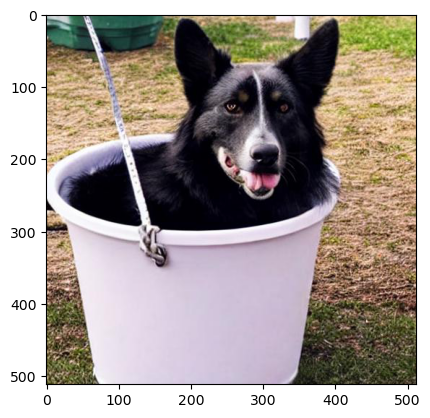

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Replace with an appropriate file name from the previous cell's output
img = mpimg.imread('/persist-data/images-new/1-af412e0096952ab3775f5e98a4f4ca313ce0fa57.jpg')
imgplot = plt.imshow(img)
plt.show()